In [23]:
#Problem 6 - Building Decision Tree
#Xingchen Zhou

In [58]:
import scipy
import scipy.io
import numpy as np
import math
from sklearn.preprocessing import scale
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from collections import Counter
import matplotlib.pyplot as plt
import queue

In [59]:
# Loading and Preprocessing data
data = scipy.io.loadmat('hw1data.mat')
X = data['X']
Y = data['Y']
X = SelectKBest(chi2, k=200).fit_transform(X, Y)  #Select top 200 features with highest variance


In [60]:
class TreeNode:
    def __init__(self, threshold, feature, decision):
        self.threshold = threshold 
        self.feature = feature     #Range: 0 to 199
        self.decision = decision   #Range: 0 to 9
        self.left = None
        self.right = None
        

In [61]:
# Calculate entropy(information purity)
# indicies is a list containing the current group's numbers 
# Y contains assigned labels
def entropy(indices, Y):
    sum_value = 0
    label_tally = [0]
    label_tally *= 10
    for index in indices:
        label_tally[Y[index][0]] += 1
    for label in label_tally:
        if label == 0: continue  #The tally number of a particular is zero
        sum_value += label / len(indices) * math.log(len(indices) / label, 2)
    return sum_value


In [74]:
# ID3 Algorithm Implementation
# The hyperparameter K is the depth of the tree that we want to build
def buildTreeNode(X, Y, indices, selected_features, depth):
    #Base case 1: Build a terminal node based on the majority label when depth is 0
    if depth == 0: 
        label = [0]
        label *= 10
        for index in indices:
            label[Y[index][0]] += 1
        majority_index = label.index(max(label))
        new_treenode = TreeNode(None, None, majority_index)
        return new_treenode
    
    #Base case 2: all examples have the same label; Create a terminal node and return
    label = [0]
    label *= 10
    for index in indices:
        label[Y[index][0]] +=1
    if len(indices) in label:
        new_treenode = TreeNode(None, None, label.index(len(indices)))  
        return new_treenode
    
    

    threshold_list = [i * 10 for i in range(1,25,4)] # For faster training time: can be improved if select smaller step
    
    group1 = []
    group2 = []
    optimal_feature_index = 0
    optimal_threshold = 0
    initial_entropy = entropy(indices, Y)
    max_gain_so_far = 0
    
    for i in range(len(X[0])):
        if i not in selected_features:  # Don't select previously selected features in the tree
            for threshold in threshold_list:
                tmp_group1 = []
                tmp_group2 = []

#                 print("This is the feature: " + str(i)) #debug
#                 print("This is the threshold: " + str(threshold)) #debug
#                 print("Depth left to build: " + str(depth))  #debug

                for j in indices:
                    if X[j][i] < threshold: tmp_group1.append(j)
                    else: tmp_group2.append(j)

                if len(tmp_group1) == len(indices) or len(tmp_group1) == 0: continue  #This paticular feature and threshold doesn't yield any information gain

#                 print("size of group 1: " + str(len(tmp_group1))) #debug
#                 print("size of group 2: " + str(len(tmp_group2))) #debug

                tmp_gain = initial_entropy - entropy(tmp_group1, Y) * len(tmp_group1) / len(indices) - \
                entropy(tmp_group2, Y) * len(tmp_group2) / len(indices)

                if tmp_gain > max_gain_so_far: 
                    max_gain_so_far = tmp_gain
                    group1 = tmp_group1
                    group2 = tmp_group2
                    optimal_feature_index = i
                    optimal_threshold = threshold
                
               
    new_treenode = TreeNode(optimal_threshold, optimal_feature_index, None)
    selected_features.add(optimal_feature_index)
    s1 = set(selected_features)
    s2 = set(selected_features)
    new_treenode.left = buildTreeNode(X, Y, group1, s1, depth - 1)
    new_treenode.right = buildTreeNode(X, Y, group2, s2, depth - 1)

    return new_treenode

In [75]:
# Get the classification (predicated label: 0 ~ 9) for a particular image
def getDecision(root, index, X):
    if root == None: return -1
    if root.decision != None: return root.decision
    
    if X[index][root.feature] < root.threshold: return getDecision(root.left, index, X)
    else: return getDecision(root.right, index, X)  

In [64]:
# Visualize the decision tree (can be improved to enhance visibility)
def treeLevelOrderTraversal(root):
    if root == None: return
    q = queue.Queue()
    q.put(root)
    count = 1
    while q.qsize() != 0:
        cur_size = q.qsize()
        print("Layer: " + str(count))
        while cur_size != 0:
            tmp_treenode = q.get()
            cur_size -= 1
            if tmp_treenode.decision != None: 
                print(tmp_treenode.decision)
                continue
            print("Threshold " + str(tmp_treenode.threshold) + " ", end='')
            print("Feature " + str(tmp_treenode.feature) + " ", end='')
            if tmp_treenode.left != None: q.put(tmp_treenode.left)
            if tmp_treenode.right != None: q.put(tmp_treenode.right)
        print()
        count += 1

import timeit

indices = list(range(8000))
selected_features = set()

start = timeit.default_timer()

treeNode_ = buildTreeNode(X, Y, indices, selected_features, 15)

stop = timeit.default_timer()
print("Total running time: " + str(stop - start))

treeLevelOrderTraversal(treeNode_)

In [84]:
# Return accuracy
# root: decision tree's root
# indices: test data
def test(root, indices):
#     indices = [i for i in range(8000, 10000)]
    count_correct = 0
    for index in indices:
        if getDecision(root, index, X) == Y[index][0]: count_correct += 1
#     print("We have predicated " + str(count_correct) + " times correctly out of " + str(len(indices)) + " !")
    return count_correct / len(indices)

In [98]:
# Problem 2: random split data - training:testing = 8/2
# Plot the training error and test error as a function of K

# e.g. depth_list = [1,2,3,4,5,...,20]
# Returns two dictionaries - training_error and testing_error
def errorTestingWithDifferentDepth(depth_list):
    indices_training = list(range(8000))
    indices_testing = list(range(8000, 10000))
    training_error = {}
    testing_error = {}

    for depth in depth_list:
        selected_features = set()
        root = buildTreeNode(X, Y, indices_training, selected_features, depth)
        training_error[depth] = test(root, indices_training)
        testing_error[depth] = test(root, indices_testing)
    
    return training_error, testing_error

In [99]:
# Different depths we want to try
# Split into two tests in case something goes wrong
depth_list1 = [i for i in range(2,11,2)]
print(depth_list1)
depth_list2 = [i for i in range(10,22,2)]
print(depth_list2)

[2, 4, 6, 8, 10]
[10, 12, 14, 16, 18, 20]


In [100]:
# Training:Testing = 8/2 - Training error and testing error when depth is 2, 4, 6, 8, 10
training_error1, testing_error1 = errorTestingWithDifferentDepth(depth_list1)

In [106]:
# Training:Testing = 8/2 - Training error and testing error when depth is 10, 12, 14, 16, 18, 20
training_error2, testing_error2 = errorTestingWithDifferentDepth(depth_list2)

In [110]:
print(training_error1.keys())

dict_keys([2, 4, 6, 8, 10])


In [111]:
print(training_error1.values())

dict_values([0.357, 0.594375, 0.741875, 0.848125, 0.944])


In [105]:
print(testing_error1.values())

dict_values([0.3525, 0.5875, 0.711, 0.7635, 0.7845])


In [112]:
print(training_error2.keys())

dict_keys([10, 12, 14, 16, 18, 20])


In [113]:
print(training_error2.values())

dict_values([0.944, 0.984875, 0.993875, 0.99775, 0.99925, 1.0])


In [114]:
print(testing_error2.values())

dict_values([0.7845, 0.787, 0.785, 0.7835, 0.785, 0.784])


In [163]:
hyper_k = [i for i in range(2,21,2)]

training_error_list = []
training_error_list += list(training_error1.values())[:-1]
training_error_list += list(training_error2.values())

testing_error_list = []
testing_error_list += list(testing_error1.values())[:-1]
testing_error_list += list(testing_error2.values())


print(training_error_list)
print(testing_error_list)

training_error_list = [1 - val for val in training_error_list]
testing_error_list = [1 - val for val in testing_error_list]

[0.357, 0.594375, 0.741875, 0.848125, 0.944, 0.984875, 0.993875, 0.99775, 0.99925, 1.0]
[0.3525, 0.5875, 0.711, 0.7635, 0.7845, 0.787, 0.785, 0.7835, 0.785, 0.784]


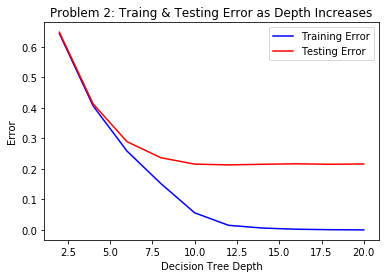

In [164]:
plt.plot(hyper_k, training_error_list, '-b', label = "Training Error")
plt.plot(hyper_k, testing_error_list, '-r', label = "Testing Error")
plt.legend()
plt.xlabel("Decision Tree Depth")
plt.ylabel("Error")
plt.title("Problem 2: Traing & Testing Error as Depth Increases")
plt.show()

In [115]:
# Problem 3: for a different random splits, how the trends of training/testing error change?

# Random split data - training:testing = 7/3
# e.g. depth_list = [1,2,3,4,5,...,20]
# Returns two dictionaries - training_error and testing_error
def errorTestingWithDifferentDepth1(depth_list):
    indices_training = list(range(7000))
    indices_testing = list(range(7000, 10000))
    training_error = {}
    testing_error = {}

    for depth in depth_list:
        selected_features = set()
        root = buildTreeNode(X, Y, indices_training, selected_features, depth)
        training_error[depth] = test(root, indices_training)
        testing_error[depth] = test(root, indices_testing)
    
    return training_error, testing_error



In [116]:
training_error3, testing_error3 = errorTestingWithDifferentDepth1(depth_list1)

In [119]:
training_error4, testing_error4 = errorTestingWithDifferentDepth1(depth_list2)

In [161]:
training_error_list1 = []
training_error_list1 += list(training_error3.values())[:-1]
training_error_list1 += list(training_error4.values())

testing_error_list1 = []
testing_error_list1 += list(testing_error3.values())[:-1]
testing_error_list1 += list(testing_error4.values())

print(training_error_list1)
print(testing_error_list1)
training_error_list1 = [1 - val for val in training_error_list1]
testing_error_list1 = [1 - val for val in testing_error_list1]

[0.34185714285714286, 0.5832857142857143, 0.74, 0.8494285714285714, 0.956, 0.9905714285714285, 0.9957142857142857, 0.9978571428571429, 0.9998571428571429, 1.0]
[0.32466666666666666, 0.5746666666666667, 0.699, 0.764, 0.779, 0.7783333333333333, 0.7773333333333333, 0.7766666666666666, 0.777, 0.777]


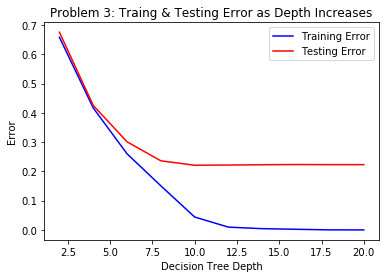

In [162]:
plt.plot(hyper_k, training_error_list1, '-b', label = "Training Error")
plt.plot(hyper_k, testing_error_list1, '-r', label = "Testing Error")
plt.legend()
plt.xlabel("Decision Tree Depth")
plt.ylabel("Error")
plt.title("Problem 3: Traing & Testing Error as Depth Increases")
plt.show()